# Intento 6

En este intento volvemos al batch_size
de 32 y añadimos una tercera capa de convolución
de 64 filtros (junto con otra de Maxpooling 2x2).
También probamos a reducir el índice de olvido al 20% 
para poder evaluar mejor la aportación de esta 
nueva capa al modelo.

## 0. Descarga del dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

train_ds_path  ='../../deeplearning-az/datasets/Part 2 - Convolutional Neural Networks (CNN)/dataset/training_set'
test_ds_path   ='../../deeplearning-az/datasets/Part 2 - Convolutional Neural Networks (CNN)/dataset/test_set'
cat_or_dog_path='../../deeplearning-az/datasets/Part 2 - Convolutional Neural Networks (CNN)/dataset/single_prediction/cat_or_dog_1.jpg'

#train_ds_path  ='C:/Users/Usuario/Documents/Master/Aprendizaje Profundo/Udemy/deeplearning-az/datasets/Part 2 - Convolutional Neural Networks (CNN)/dataset/training_set'
#test_ds_path   ='C:/Users/Usuario/Documents/Master/Aprendizaje Profundo/Udemy/deeplearning-az/datasets/Part 2 - Convolutional Neural Networks (CNN)/dataset/test_set'
#cat_or_dog_path='C:/Users/Usuario/Documents/Master/Aprendizaje Profundo/Udemy/deeplearning-az/datasets/Part 2 - Convolutional Neural Networks (CNN)/dataset/single_prediction/cat_or_dog_1.jpg'

#train_ds_path  ='.\\data\\training_set'
#test_ds_path   ='.\\data\\test_set'
#cat_or_dog_path='.\\data\\single_prediction\\cat_or_dog_1.jpg'


Primero, importar las librerías y paquetes

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
# Nota, algunas capas no están importadas aquí y se importan directamente en el código con tf.keras.laters.[CAPA]

import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import random as rn

Fijamos seeds para poder reproducir resultados (aunque aun así a veces no lo conseguimos, probablementa haya inicializaciones que no dependan de estas seeds)

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.random.set_seed(1234)

## 1. Construcción del modelo CNN añadiendo un tamaño de imagen mayor


El tamaño de imagen que emplearemos será de 96x96, y el dropout rate es del 50%

In [4]:
frame_size = (96, 96)
"""
esta dupla nos permitirá parametrizar la resolución
de entrada de las imágenes
"""

def crear_clasificador_intento6():
    classifier = Sequential()
    classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), 
                      input_shape = (*frame_size, 3), activation = "relu"))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), activation = "relu"))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    classifier.add(Conv2D(filters = 64,kernel_size = (3, 3), activation = "relu"))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    classifier.add(Flatten())
    classifier.add(Dense(units = 128, activation = "relu"))
    classifier.add(Dropout(0.2))
    classifier.add(Dense(units = 1, activation = "sigmoid"))    
    return classifier

## 2. Entrenamiento del intento 6

En primer lugar instanciamos nuestro modelo y compilamos usando:
* Un optimizador Adam. La learning rate que emplea por defecto es 0.001
* Binary cross entropy como función de coste a minimizar.  

In [5]:
classifier = crear_clasificador_intento6()
classifier.compile(optimizer = "adam", 
                   loss = "binary_crossentropy", 
                   metrics = ["accuracy"])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0

En segundo lugar, generamos los datasets de entrenamiento y test.
Emplearemos un **tamaño de batch de 32**

In [6]:
from keras.preprocessing.image import ImageDataGenerator

batch_size=32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(train_ds_path,
                                                     target_size=frame_size,
                                                     batch_size=batch_size,
                                                     class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(test_ds_path,
                                                   target_size=frame_size,                                                   
                                                   batch_size=batch_size,
                                                   class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Definimos el callback y realizamos el entrenamiento con las condiciones descritas en la sección de introducción.

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience=5),
]                                                   
                                                   
history1 = classifier.fit(x=training_dataset,
                         steps_per_epoch=8000/batch_size,
                         epochs=100,
                         validation_data=testing_dataset,
                         validation_steps=2000/batch_size,
                         workers=4) # "Si pedimos más de un proceso el rendimiento mejora un poco


Epoch 1/100
250/250 [==============================] - 64s 257ms/step - loss: 0.6726 - accuracy: 0.5761 - val_loss: 0.6280 - val_accuracy: 0.6505
Epoch 2/100
250/250 [==============================] - 64s 258ms/step - loss: 0.6050 - accuracy: 0.6625 - val_loss: 0.5728 - val_accuracy: 0.7005
Epoch 3/100
250/250 [==============================] - 65s 259ms/step - loss: 0.5668 - accuracy: 0.7040 - val_loss: 0.5317 - val_accuracy: 0.7295
Epoch 4/100
250/250 [==============================] - 64s 256ms/step - loss: 0.5340 - accuracy: 0.7343 - val_loss: 0.5045 - val_accuracy: 0.7520
Epoch 5/100
250/250 [==============================] - 67s 268ms/step - loss: 0.5000 - accuracy: 0.7555 - val_loss: 0.5228 - val_accuracy: 0.7430
Epoch 6/100
250/250 [==============================] - 63s 253ms/step - loss: 0.4728 - accuracy: 0.7690 - val_loss: 0.4564 - val_accuracy: 0.7880
Epoch 7/100
250/250 [==============================] - 61s 244ms/step - loss: 0.4607 - accuracy: 0.7843 - val_loss: 0.4446 -

Epoch 57/100
250/250 [==============================] - 60s 238ms/step - loss: 0.1255 - accuracy: 0.9499 - val_loss: 0.6195 - val_accuracy: 0.8260
Epoch 58/100
250/250 [==============================] - 58s 233ms/step - loss: 0.1248 - accuracy: 0.9520 - val_loss: 0.6331 - val_accuracy: 0.8405
Epoch 59/100
250/250 [==============================] - 59s 236ms/step - loss: 0.1308 - accuracy: 0.9471 - val_loss: 0.5211 - val_accuracy: 0.8525
Epoch 60/100
250/250 [==============================] - 61s 243ms/step - loss: 0.1333 - accuracy: 0.9473 - val_loss: 0.5735 - val_accuracy: 0.8425
Epoch 61/100
250/250 [==============================] - 59s 235ms/step - loss: 0.1357 - accuracy: 0.9450 - val_loss: 0.7643 - val_accuracy: 0.8125
Epoch 62/100
250/250 [==============================] - 59s 236ms/step - loss: 0.1362 - accuracy: 0.9461 - val_loss: 0.5254 - val_accuracy: 0.8395
Epoch 63/100
250/250 [==============================] - 58s 234ms/step - loss: 0.1142 - accuracy: 0.9565 - val_loss: 0

Ploteamos el resultado

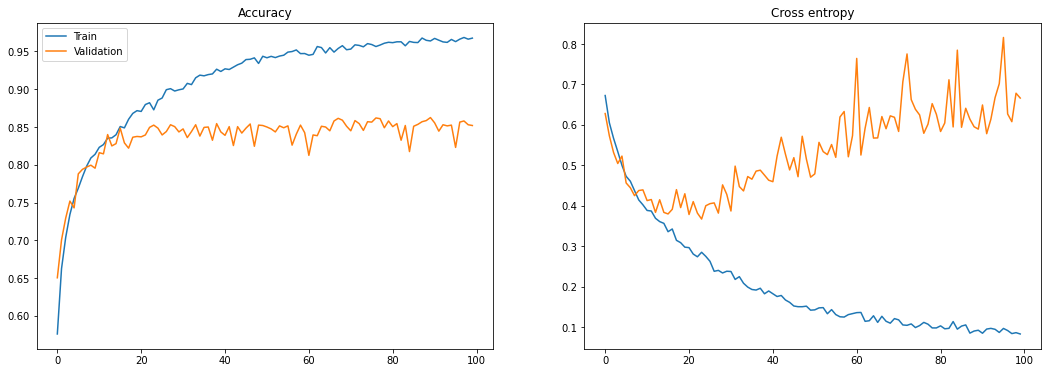

In [8]:
def plot_resultados_training(history):
    fig, axes = plt.subplots(1,2, figsize=(18,6))
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].legend()
    axes[0].set_title('Accuracy')
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Cross entropy')

plot_resultados_training(history1)

In [9]:
classifier.save('./models/clasificador6')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/clasificador6/assets


## Comentario
En este intento hemos ampliado a tres capas de convolución con 32, 32 y 64 filtros de 3x3. 
El resultado ha sido esperanzador, pues hemos llegado a una precisón del 85.2% en validación. 

## Propuesta de mejora
Los mejora de resultados en cuanto hemos *complicado* la arquitectura de las capas convolucionales 
nos hace pensar que quizás ese sea el camino. 